In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from transformer_lens import HookedTransformer

from unlearning.tool import get_hf_model
from unlearning.feature_activation import get_forget_retain_data, tokenize_dataset, get_feature_activation_sparsity, get_top_features
from unlearning.jump_relu import load_gemma2_2b_sae
from unlearning.intervention import scaling_intervention
from unlearning.metrics import calculate_MCQ_metrics, get_loss_added_hf, create_df_from_metrics, generate_ablate_params_list

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle

In [2]:
layer = 3
sae = load_gemma2_2b_sae(layer=layer)


model = HookedTransformer.from_pretrained('google/gemma-2-2b-it')

Found SAE with l0=59 at path google/gemma-scope-2b-pt-res/layer_3/width_16k/average_l0_59/params.npz


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b-it into HookedTransformer


In [3]:
from sae.activation_store import ActivationsStore

sae.cfg.dataset = "Skylion007/openwebtext"
sae.cfg.n_batches_in_store_buffer = 8

activation_store = ActivationsStore(sae.cfg, model, create_dataloader=False)

In [4]:
top_features = np.loadtxt(f'../data/top_features/gemma-2-2b-it-sparsity/layer3.txt', dtype=int)
top_features

array([ 8786,  3025, 11913, ...,  2203, 13035, 12031])

In [5]:
forget_sparsity = np.loadtxt(f'../data/top_features/gemma-2-2b-it-sparsity/layer3_mean_feature_activation_forget.txt', dtype=float)
retain_sparsity = np.loadtxt(f'../data/top_features/gemma-2-2b-it-sparsity/layer3_mean_feature_activation_retain.txt', dtype=float)

forget_sparsity

array([0.003672, 0.00634 , 0.031799, ..., 0.00067 , 0.000165, 0.006161])

In [6]:
from unlearning.feature_activation import get_top_features
top_features_custom = get_top_features(forget_sparsity, retain_sparsity, retain_threshold=0.01)

[ 8786  3025 11913 14227   679  1082 10793  6691  8803  8934  9839 16064
   616 10238 16169  8396 13219 11380  3061  2659]


In [7]:
top_features_custom[:10]

array([ 8786,  3025, 11913, 14227,   679,  1082, 10793,  6691,  8803,
        8934])

In [8]:
multipliers = [1, 5, 10, 50, 100, 200, 300]

In [9]:
# Calculate metrics
from unlearning.metrics import calculate_metrics_list

main_ablate_params = {
    'intervention_method': 'clamp_feature_activation_random',
    'features_to_ablate': list(top_features_custom[:10]),
}


sweep = {
         'multiplier': multipliers,
        }


# dataset_names = all_dataset_names[:2]
dataset_names = ['loss_added', 'wmdp-bio']

n_batch_loss_added = 10

metrics_random = calculate_metrics_list(
    model,
    sae,
    main_ablate_params,
    sweep,
    dataset_names=dataset_names,
    include_baseline_metrics=False,
    split='all',
    verbose=False,
    activation_store=activation_store,
    target_metric='correct',
    n_batch_loss_added=n_batch_loss_added
)


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [06:39<00:00, 57.08s/it]


In [10]:
# Calculate metrics
from unlearning.metrics import calculate_metrics_list

main_ablate_params = {
    'intervention_method': 'clamp_feature_activation',
    'features_to_ablate': list(top_features_custom[:10]),
}


sweep = {
         'multiplier': multipliers,
        }


# dataset_names = all_dataset_names[:2]
dataset_names = ['loss_added', 'wmdp-bio']

n_batch_loss_added = 10

metrics = calculate_metrics_list(
    model,
    sae,
    main_ablate_params,
    sweep,
    dataset_names=dataset_names,
    include_baseline_metrics=False,
    split='all',
    verbose=False,
    activation_store=activation_store,
    target_metric='correct',
    n_batch_loss_added=n_batch_loss_added
)


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [06:55<00:00, 59.34s/it]


In [11]:
for m in metrics:
    print(m['wmdp-bio']['mean_correct'])

0.9961685538291931
0.9770114421844482
0.9463601112365723
0.5842911601066589
0.3927203118801117
0.31992337107658386
0.28735631704330444


In [12]:
for m in metrics_random:
    print(m['wmdp-bio']['mean_correct'])

1.0
1.0
0.9980842471122742
0.8697317838668823
0.561302661895752
0.3735632002353668
0.3256704807281494


In [13]:
df = []

for multiplier, metric in zip(multipliers, metrics):
    row = {}
    for k, v in metric.items():
        if k == 'loss_added':
            row['loss_added'] = v.item()
        else:
            row[k] = v['mean_correct']
    row['random'] = False
    row['multiplier'] = multiplier
    df.append(row)
    
for multiplier, metric in zip(multipliers, metrics_random):
    row = {}
    for k, v in metric.items():
        if k == 'loss_added':
            row['loss_added'] = v.item()
        else:
            row[k] = v['mean_correct']
    row['random'] = True
    row['multiplier'] = multiplier
    df.append(row)
    
df = pd.DataFrame(df)
df

,loss_added,wmdp-bio,random,multiplier
0,-0.002937,0.996169,False,1
1,-0.003856,0.977011,False,5
2,-0.004859,0.946360,False,10
3,-0.003834,0.584291,False,50
4,0.037140,0.392720,False,100
5,0.335909,0.319923,False,200
6,0.737150,0.287356,False,300
7,0.000209,1.000000,True,1
8,0.001128,1.000000,True,5
9,0.002455,0.998084,True,10


In [2]:
df = pd.read_csv('../data/random_decoder/gemma-2-2b-it_random_decoder_resutls.csv')
df

,loss_added,wmdp-bio,random,multiplier
0,-0.002937,0.996169,False,1
1,-0.003856,0.977011,False,5
2,-0.004859,0.946360,False,10
3,-0.003834,0.584291,False,50
4,0.037140,0.392720,False,100
5,0.335909,0.319923,False,200
6,0.737150,0.287356,False,300
7,0.000209,1.000000,True,1
8,0.001128,1.000000,True,5
9,0.002455,0.998084,True,10


In [3]:
import matplotlib as mpl
from cycler import cycler

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 1.4

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.major.width'] = 0.4
mpl.rcParams['xtick.minor.width'] = 0.4
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.major.width'] = 0.4
mpl.rcParams['ytick.minor.width'] = 0.4
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10


mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 9

mpl.rcParams['figure.figsize'] = 6, 4

mpl.rcParams['axes.prop_cycle'] = cycler("color", ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff7f0e']

# Plotting
fig_dir = "../figs"

def create_lineplot_histogram(distribution, bins=20):
    vals, bin_edges = np.histogram(distribution, bins=bins)

    xvals = np.repeat(bin_edges, 2)
    yvals = np.repeat(vals, 2)
    yvals = np.concatenate(([0], yvals, [0]))

    return xvals, yvals

In [4]:
model_name = 'gemma-2-2b-it'

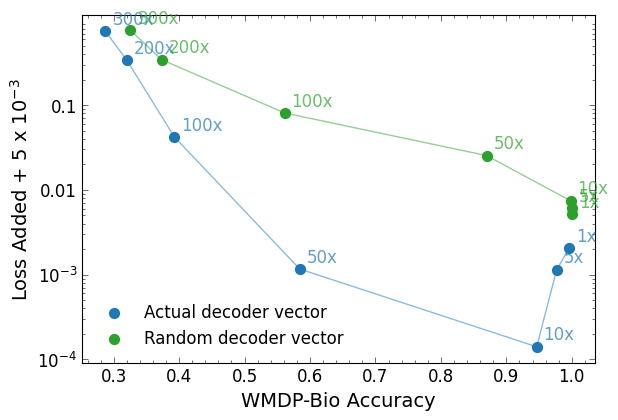

In [8]:
def plot_metrics(df, x_col, y_col, color_col, fig_name):
    fig, ax = plt.subplots(figsize=(6, 4))

    if y_col == 'loss_added':
        # y_min = df[y_col].min()
        # offset = abs(y_min) + 1e-4 if y_min <= 0 else 0
        # print(offset)
        offset = 5e-3
        
    # Get unique values
    unique_values = df[color_col].unique()
    labels = {True: 'Random decoder vector', False: 'Actual decoder vector'}
    
    # Create a scatter plot and line for each unique value
    for i, value in enumerate(unique_values):
        subset = df[df[color_col] == value].sort_values(by=x_col)
        color = colors[i % len(colors)]
        
        if y_col == 'loss_added':
            y_values = np.log10(subset[y_col] + offset)
        else:
            y_values = subset[y_col]
        # Plot line
        ax.plot(subset[x_col], y_values, color=color, alpha=0.5)
        
        # Plot scatter points
        ax.scatter(subset[x_col], y_values, 
                    c=[color], label=labels[value], s=50)
        
        # Add multiplier labels
        for x, y, mult in zip(subset[x_col], y_values, subset['multiplier']):
            ax.annotate(f"{mult}x", (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=12, 
                        alpha=0.7, color=color)
    

    yticks = [-4, -3, -2, -1]
    yticklabels = [r"10$^{-4}$", r"10$^{-3}$", 0.01, 0.1]
    yminor_ticks = np.log10(np.concatenate((np.arange(1e-4, 1e-3, 1e-4),
                                            np.arange(1e-3, 1e-2, 1e-3),
                                            np.arange(1e-2, 1e-1, 1e-2),
                                            np.arange(1e-1, 1, 1e-1))))

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_yticks(yminor_ticks, minor=True)


    ax.legend(loc='lower left', fontsize=12)

    ax.set_xlabel('WMDP-Bio Accuracy', fontsize=14)
    ax.set_ylabel(f'Loss Added + 5 x 10$^{{-3}}$', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    

    fig.subplots_adjust(right=0.98, top=0.98)
    fig.savefig(fig_dir + f"/multiple_features/{model_name}_{fig_name}.pdf", dpi=400)
    # plt.show()


plot_metrics(
    df, 
    x_col='wmdp-bio', 
    y_col='loss_added', 
    color_col='random', 
    fig_name='random_decoder_vector',
)
